# Neighborhoods in Toronto
Applied Data Science Capstone Week 3 Assignment

## 1.  First Part of the Assginment: Scrape Wikipedia

#### Import the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
%matplotlib inline

#### Fetch the HTML content of the url and parse it with BeautifulSoup, find and reference the table with the codes

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
table = soup.find_all('table', class_='wikitable')[0]

#### Fill the initial dataframe with all uncleansed table rows
I know this causes triple iteration through the data rows. But it is more readable than a big for loop.

- Preventing the recursive search in `findChildren` will only return direct children. Not the anchors **a** contained in links.
- `get_text()` strips the HTML tags
- `strip()` strips whitespaces from the remaining string

In [3]:
df = pd.DataFrame({
    'PostalCode': [row.findChildren(recursive=False)[0].get_text().strip() for row in table.select('tr')],
    'Borough': [row.findChildren(recursive=False)[1].get_text().strip() for row in table.select('tr')],
    'Neighborhood': [row.findChildren(recursive=False)[2].get_text().strip() for row in table.select('tr')]
})

#### Drop the first row containing the header information

In [4]:
df = df.iloc[1:]

#### Drop the 'Not assigned' boroughs:

In [5]:
df = df[df['Borough']!='Not assigned']

#### Replace the Neighborhood if it is not assigned

In [6]:
df['Neighborhood'] = df.apply(lambda x: x['Borough'] if x['Neighborhood'] == 'Not assigned' else x['Neighborhood'], axis=1)

#### Group By Postal Code and Borough and concatenate Neighborhood

In [7]:
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).reset_index()
df.head(12)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [8]:
df.shape

(103, 3)

## 2. Second part of the Assignment: Fetch Geo location data

#### Unable to fetch locations from geocoder... therefore I had to use the CSV

    # !pip install geocoder
    # import geocoder # import geocoder
    # 
    # def fetchFromGeoCoder(pc):
    #     lat_lng_coords = None
    #     while(lat_lng_coords is None):
    #         g = geocoder.google('{}, Toronto, Ontario'.format(pc))
    #         lat_lng_coords = g.latlng
    #     return lat_lng_coords
    # 
    # df['latlng'] = df.apply(lambda x: fetchFromGeoCoder(x['PostalCode']), axis=1)

#### Fetch the geospatial data

In [9]:
locations = pd.read_csv('http://cocl.us/Geospatial_data')

#### Prepare the PC column name for the merge

In [10]:
locations.rename(columns={'Postal Code':'PostalCode'}, inplace=True)

#### Merge the two data sets

In [11]:
df = pd.merge(df, locations, how='left', on='PostalCode')

In [12]:
df.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## 3. Third part of the Assignment: Clustering the data

In [13]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 geopy --yes
import folium
from geopy.geocoders import Nominatim
import requests

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
geopy                     1.18.1                     py_0    conda-forge


### 3.1 Download and Explore the Dataset

#### Fetch the center of Toronto

In [14]:
geolocator = Nominatim(user_agent="ds-learning")
location = geolocator.geocode('Toronto, Ontario')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Display the map of Toronto

In [15]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for index, row in df.iterrows():
    label = '{}: {} ({})'.format(row['Borough'], row['Neighborhood'], row['PostalCode'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Subselection of Boroughs containing Toronto in their names

In [16]:
df['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [17]:
toronto_data = df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [18]:
map_toronto_center = folium.Map(location=[latitude, longitude], zoom_start=12)

for index, row in toronto_data.iterrows():
    label = folium.Popup(row['Neighborhood'], parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_center)  
    
map_toronto_center

### 3.2 Explore Neighborhoods in Toronto

#### Define secret Foursquare API parameters

In [19]:
# The code was removed by Watson Studio for sharing.

#### Define not so secret Foursquare API parameters

In [20]:
LIMIT = 100
VERSION = '20180605'

#### Define previously Foursquare nearby venues fetching function

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

(1700, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
2,The Beaches,43.676357,-79.293031,My Bbq,43.676881,-79.289286,BBQ Joint
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Fearless Meat,43.680337,-79.290289,Burger Joint


In [23]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business reply mail Processing Centre969 Eastern,19,19,19,19,19,19
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",98,98,98,98,98,98
Christie,16,16,16,16,16,16


In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


### 3.3 Analyze Each Neighborhood

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# There seems to be a category called 'Neighborhood':
toronto_onehot.rename(columns={'Neighborhood':'Neighborhood_Cat'}, inplace=True)

toronto_onehot = pd.concat([toronto_venues['Neighborhood'], toronto_onehot], axis=1)
toronto_onehot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
toronto_onehot.shape

(1700, 240)

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.00000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Business reply mail Processing Centre969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048,...,0.00000,0.000000,0.012048,0.000000,0.000000,0.012048,0.000000,0.000000,0.00,0.012048
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.051020,0.000000,0.051020,0.010204,0.000000,0.000000,0.00,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.011905,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.00000,0.000000,0.000000,0.011905,0.011905,0.000000,0.011905,0.011905,0.00,0.011905


In [28]:
toronto_grouped.shape

(38, 240)

#### Let's print each neighborhood along with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2      Thai Restaurant  0.04
3           Steakhouse  0.04
4  American Restaurant  0.04


----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2    Restaurant  0.05
3        Bakery  0.04
4    Steakhouse  0.04


----Brockton, Exhibition Place, Parkdale Village----
                  venue  freq
0           Coffee Shop  0.14
1        Breakfast Spot  0.10
2                  Café  0.10
3                   Gym  0.05
4  Gym / Fitness Center  0.05


----Business reply mail Processing Centre969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1         Yoga Studio  0.05
2       Garden Center  0.05
3          Smoke Shop  0.05
4       Auto Workshop  0.05


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0  Airport Terminal  0.14
1    Air

#### Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Gym,Clothing Store,Asian Restaurant,Bakery,Bar
1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Pub,Café,Cheese Shop,Seafood Restaurant,Farmers Market,Steakhouse,Italian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym / Fitness Center,Furniture / Home Store,Convenience Store,Climbing Gym,Caribbean Restaurant,Burrito Place,Falafel Restaurant
3,Business reply mail Processing Centre969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Moving Target,Recording Studio,Restaurant,Burrito Place,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Plane,Boutique,Sculpture Garden,Harbor / Marina,Airport Gate,Airport Food Court,Airport


### 3.4 Cluster Neighborhoods

#### First find best k

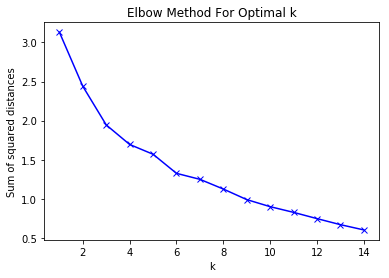

In [32]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
ssq = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=3).fit(toronto_grouped_clustering)
    ssq.append(kmeans.inertia_)

plt.plot(K, ssq, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

k=6 seems to yield good enough results, re-run with k=6

In [33]:
kclusters = 6
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(toronto_grouped_clustering)
print(kmeans.inertia_)
kmeans.labels_[0:10]


1.32581617378


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Rejoin the datasets to create the map

In [34]:
toronto_merged = toronto_data
toronto_merged['Cluster Labels'] = kmeans.labels_
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,BBQ Joint,Neighborhood_Cat,Coffee Shop,Burger Joint,Pub,Yoga Studio,Donut Shop,Dog Run,Doner Restaurant,Dumpling Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Furniture / Home Store,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Pizza Place,Light Rail Station,Movie Theater,Liquor Store,Board Shop,Burger Joint,Fast Food Restaurant,Burrito Place,Fish & Chips Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Coworking Space,Brewery,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Bus Line,Dim Sum Restaurant,Park,Swim School,Lake,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio


Finally, let's visualize the resulting clusters

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.5 Examine Clusters

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,BBQ Joint,Neighborhood_Cat,Coffee Shop,Burger Joint,Pub,Yoga Studio,Donut Shop,Dog Run,Doner Restaurant,Dumpling Restaurant
1,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Furniture / Home Store,Pub,Pizza Place,Liquor Store
2,East Toronto,0,Sandwich Place,Pizza Place,Light Rail Station,Movie Theater,Liquor Store,Board Shop,Burger Joint,Fast Food Restaurant,Burrito Place,Fish & Chips Shop
3,East Toronto,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Coworking Space,Brewery,Sandwich Place
4,Central Toronto,0,Bus Line,Dim Sum Restaurant,Park,Swim School,Lake,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
5,Central Toronto,0,Food & Drink Shop,Sandwich Place,Park,Burger Joint,Home Service,Breakfast Spot,Dance Studio,Hotel,Dumpling Restaurant,Doner Restaurant
6,Central Toronto,0,Coffee Shop,Sporting Goods Shop,Clothing Store,Grocery Store,Gift Shop,Fast Food Restaurant,Mexican Restaurant,Diner,Dessert Shop,Park
7,Central Toronto,0,Pizza Place,Sandwich Place,Dessert Shop,Seafood Restaurant,Sushi Restaurant,Coffee Shop,Italian Restaurant,Café,Farmers Market,Brewery
8,Central Toronto,0,Playground,Trail,Yoga Studio,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
9,Central Toronto,0,Coffee Shop,Pub,Pizza Place,American Restaurant,Sports Bar,Bagel Shop,Supermarket,Sushi Restaurant,Fried Chicken Joint,Light Rail Station


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Pub,Cocktail Bar,Seafood Restaurant,Hotel,Italian Restaurant,Gym,Cosmetics Shop


In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,2,Coffee Shop,Café,Italian Restaurant,Bar,Sandwich Place,Bubble Tea Shop,Burger Joint,Ice Cream Shop,Falafel Restaurant,Indian Restaurant
27,Downtown Toronto,2,Airport Lounge,Airport Terminal,Airport Service,Plane,Boutique,Sculpture Garden,Harbor / Marina,Airport Gate,Airport Food Court,Airport


In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Ice Cream Shop,Garden,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Central Toronto,4,Coffee Shop,Sandwich Place,Café,Pizza Place,Park,Liquor Store,Burger Joint,Jewish Restaurant,French Restaurant,BBQ Joint


In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,West Toronto,5,Breakfast Spot,Gift Shop,Italian Restaurant,Dessert Shop,Burger Joint,Eastern European Restaurant,Bar,Bank,Restaurant,Movie Theater
